In [1]:
# add dependencies
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import time

from sqlalchemy import create_engine
from sqlalchemy.orm import Session
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()
from sqlalchemy.ext.automap import automap_base

from sqlalchemy import Column, Integer, String, Float, and_, Date, desc, func

In [2]:
# collect the start and end dates of the trip
date_entry = input('Enter a start date for your trip in YYYY-MM-DD format: ')
year, month, day = map(int, date_entry.split('-'))
start_date = datetime.date(year, month, day)

date_entry = input('Enter an end date for your trip in YYYY-MM-DD format: ')
year, month, day = map(int, date_entry.split('-'))
end_date = datetime.date(year, month, day)

Enter a start date for your trip in YYYY-MM-DD format: 2015-01-01
Enter an end date for your trip in YYYY-MM-DD format: 2015-02-25


In [3]:
# Use create the engine and assign classes
engine = create_engine("sqlite:///hawaii.sqlite")

# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

Station = Base.classes.Stations
Measurement = Base.classes.Measurements

session = Session(engine)

In [4]:
# get the date 1 year ago
year_ago = end_date - datetime.timedelta(365)

pcp_year = session.query(Measurement.date, Measurement.prcp).filter(and_(Measurement.date <= end_date,
                                                                        Measurement.date >= year_ago)).all()

# create the dataframe and set date as the index
pcp_df = pd.DataFrame(pcp_year, columns=["date", "precipitation"])
pcp_df.set_index('date', inplace=True)

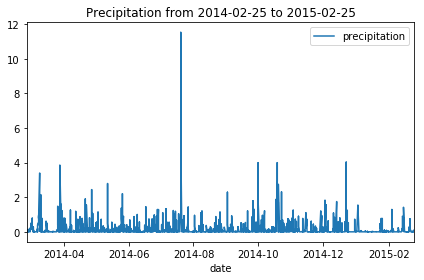

In [5]:

# Plot the dataframe as a chart using pandas plotting
pcp_df.iloc[::-1].plot(title="Precipitation from %s to %s" % (year_ago, end_date))
plt.tight_layout()
plt.show()

In [6]:
# calculate the number of stations
num_stations = session.query(Station.station).count()
print("The number of stations is: %s" % num_stations)

The number of stations is: 9


In [7]:
# find the most active station
act_stations = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).order_by(desc(func.count(Measurement.date))).all()

most_active = act_stations[0][0]
num_observations = act_stations[0][1]

print("The most active station is: %s" % most_active)
print("Number of observations for station %s: %s" % (most_active, num_observations))

The most active station is: USC00519281
Number of observations for station USC00519281: 2772


In [8]:
# get the last 12 months of temperature data

temp_year = session.query(Measurement.date, Measurement.tobs).filter(and_(Measurement.date <= end_date,
                                                                        Measurement.date >= year_ago,
                                                                         Measurement.station == most_active)).all()

# create the dataframe and set date as the index
temp_df = pd.DataFrame(temp_year, columns = ["date", "temperature"])
temp_df.set_index('date', inplace=True)

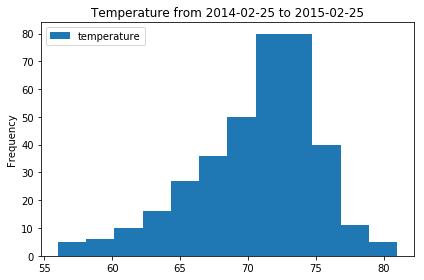

In [9]:
# create a histogram of the temperature data
temp_df.iloc[::-1].plot.hist(title="Temperature from %s to %s" % (year_ago, end_date), bins = 12)
plt.tight_layout()
plt.show()

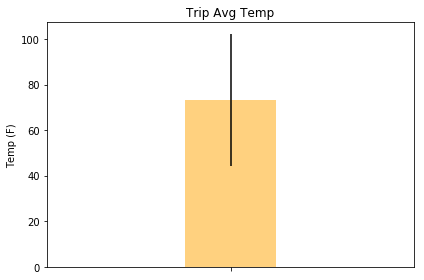

In [10]:
def calc_temps(start, end):
    # calculate the date 1 year ago
    one_year = end - datetime.timedelta(365)
    
    # get the maximum temperature
    max_temp = session.query(func.max(Measurement.tobs)).filter(and_(Measurement.date <= end, Measurement.date >= one_year)).all()
    maximum = max_temp[0][0]
    
    # get the minimum temperature
    min_temp = session.query(func.min(Measurement.tobs)).filter(and_(Measurement.date <= end, Measurement.date >= one_year)).all()
    minimum = min_temp[0][0]
    
    # get the average temperature
    avg_temp = session.query(func.avg(Measurement.tobs)).filter(and_(Measurement.date <= end, Measurement.date >= one_year)).all()
    average = avg_temp[0][0]
    
    # create the plot
    objects = [str(end)]
    x_axis = np.arange(len(objects))
    fig, ax = plt.subplots()
    temp_plot = ax.bar(x_axis, average, yerr=(maximum-minimum), color = "orange", alpha = .5, width = .5)
    tick_locations = [value for value in x_axis]
    plt.xticks(tick_locations, [])
    plt.xlim(-1, len(x_axis))
    plt.title("Trip Avg Temp")
    plt.ylabel("Temp (F)")
    plt.tight_layout()
    plt.show()

# call the function
calc_temps(start_date, end_date)